# Simon Initial Investigation & Implementation of Bag-of-Words

## Learning Pytorch: Tutorial
As of this point, I have nearly exclusively worked with TensorFlow. With this being the first week of the class, I have decided I would like to try out using Pytorch to get a feel and develop a preference. Before I dive deeper into an application to the concepts we have learned in class, I have first followed a tutorial (https://pytorch.org/tutorials/beginner/deep_learning_nlp_tutorial.html) to get started with PyTorch. Below I have performed some of the concepts from the tutorial, and have also layed out and labeled the main concepts for furture reference (somewhat like and encyclopedia). 

In [1]:
import torch
torch.manual_seed(1)

### Fundamentals
#### Initializing Tensors

In [2]:
vec=torch.tensor([1.,2.,3.]) #vector
print(vec)
mat=torch.tensor([[1.,2.,3.],[4.,5.,6.]]) #matrix
print(mat)
ten3D=torch.tensor([[[1., 2.], [3., 4.]],[[5., 6.], [7., 8.]]]) #3D tensor
print(ten3D)
randomV=torch.randn(2, 2) #random tensor
print(randomV)
zeros=torch.zeros(2,3,4) #zero tensor
print(zeros)

tensor([1., 2., 3.])
tensor([[1., 2., 3.],
        [4., 5., 6.]])
tensor([[[1., 2.],
         [3., 4.]],

        [[5., 6.],
         [7., 8.]]])
tensor([[0.6614, 0.2669],
        [0.0617, 0.6213]])
tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])


#### Indexing

In [3]:
print(vec[0])
print(vec[0].item()) #vec
print(mat[0])
print(ten3D[0,1,1].item())#order of indexing

tensor(1.)
1.0
tensor([1., 2., 3.])
4.0


#### Basic Tensor Operations

In [4]:
x=torch.tensor([1,2,3])
y=torch.tensor([4,5,6])

print(x+y) #addition

print(x*y) #Elementwise multiplicaiton

temp=torch.cat([x,y]) #concatination
print(temp)

print(sum(temp)) #summation of elements

print(temp.view(2,3)) #reshaping

tensor([5, 7, 9])
tensor([ 4, 10, 18])
tensor([1, 2, 3, 4, 5, 6])
tensor(21)
tensor([[1, 2, 3],
        [4, 5, 6]])


#### Computation Graphs and Automatic Differentiation
PyTorch can perform automatic backpropogation gradients as long as the data is specified in how it is connected so gradients can be computed. To flag that we want the data to be followed for gradient determination and backpropogation, we specify "requires_grad=True". Notice how the specified grad_fn understands what operation is being processed in the previous computation. 

In [5]:
x=torch.tensor([1.,2.,3.], requires_grad=True)
y=torch.tensor([4.,5.,6.], requires_grad=True)
z=x+y

print(z) #Now we have information about the gradient funciton for backprop
print(z[0])
print(z[0].item())
print(z.grad_fn) #Add backward
s=z.sum()
print(s.grad_fn) #Sum backward

s.backward() #backprop
print(x.grad)

z=z.detach() #Detach from history
print(z.grad_fn)

tensor([5., 7., 9.], grad_fn=<AddBackward0>)
tensor(5., grad_fn=<SelectBackward0>)
5.0
tensor([1., 1., 1.])
None


### Using Standard Deep Learning Mechanics

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1)

#### Affine Maping: Multilayered Neural Networks

In [7]:
lin = nn.Linear(5, 3) # Net from layer of dim 5 to dim 3

data = torch.randn(2, 5) 
print(data)
print(lin(data))  # linearly mapped to next layer

print(F.relu(data)) #non-linearity-- in this case ReLU

tensor([[-1.1948,  0.0250, -0.7627,  1.3969, -0.3245],
        [ 0.2879,  1.0579,  0.9621,  0.3935,  1.1322]])
tensor([[ 0.1755, -0.3268, -0.5069],
        [-0.6602,  0.2260,  0.1089]], grad_fn=<AddmmBackward0>)
tensor([[0.0000, 0.0250, 0.0000, 1.3969, 0.0000],
        [0.2879, 1.0579, 0.9621, 0.3935, 1.1322]])


#### Softmax: Turning Tensor into probability distribution

In [8]:
data = torch.randn(5)
print(data)
print(F.softmax(data, dim=0)) #Next layer becomes prob distribution
print(F.softmax(data, dim=0).sum()) 

tensor([-0.5404, -2.2102,  2.1130, -0.0040,  1.3800])
tensor([0.0418, 0.0079, 0.5936, 0.0715, 0.2852])
tensor(1.)


#### Tutorial Example: Bag-of-Words Spanish or English (Logistic Regression)

In [9]:
#Establish training data
data = [("me gusta comer en la cafeteria".split(), "SPANISH"),
        ("Give it to me".split(), "ENGLISH"),
        ("No creo que sea una buena idea".split(), "SPANISH"),
        ("No it is not a good idea to get lost at sea".split(), "ENGLISH")]

#Test Data
test_data = [("Yo creo que si".split(), "SPANISH"),
             ("it is lost on me".split(), "ENGLISH")]

#Add words to our dictionary
word_to_ix = {}
for sentence, _ in data + test_data:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
print(word_to_ix)

VOCAB_SIZE = len(word_to_ix)
NUM_LABELS = 2 #Spanish or English

##########First Define Model###############

class BoWClassifier(nn.Module):  # inheriting from nn.Module!

    def __init__(self, num_labels, vocab_size):
        # calls the init function of nn.Module.  Dont get confused by syntax,
        # just always do it in an nn.Module
        super(BoWClassifier, self).__init__()

        self.linear = nn.Linear(vocab_size, num_labels) #linear affine map

    def forward(self, bow_vec):
        temp=self.linear(bow_vec)
        return F.log_softmax(temp, dim=1) # 1 dimention for prob distribution


def make_bow_vector(sentence, word_to_ix):
    vec = torch.zeros(len(word_to_ix))
    for word in sentence:
        vec[word_to_ix[word]] += 1 #count up how many times we hit the word of interest
    return vec.view(1, -1)


def make_target(label, label_to_ix):
    return torch.LongTensor([label_to_ix[label]]) #desired classification


model = BoWClassifier(NUM_LABELS, VOCAB_SIZE) #define model

# the model knows its parameters.  The first output below is A, the second is b.
# Whenever you assign a component to a class variable in the __init__ function
# of a module, which was done with the line
# self.linear = nn.Linear(...)
# Then through some Python magic from the PyTorch devs, your module
# (in this case, BoWClassifier) will store knowledge of the nn.Linear's parameters
for param in model.parameters():
    print(param)

##########Now Training the data############
print("TRAINING...")
label_to_ix = {"SPANISH": 0, "ENGLISH": 1} #define categories
# Run on test data before we train, just to see a before-and-after
with torch.no_grad():
    for instance, label in test_data:
        bow_vec = make_bow_vector(instance, word_to_ix)
        log_probs = model(bow_vec)
        print(log_probs)
# Print the matrix column corresponding to "creo"
print(next(model.parameters())[:, word_to_ix["creo"]])


loss_function = nn.NLLLoss() #define loss function
optimizer = optim.SGD(model.parameters(), lr=0.1) #define optimizer

#Pass over training set each epoch
for epoch in range(100):
    count=0
    for instance, label in data:
        model.zero_grad() # Re-clear all gradients before restarting an epoch
        
        #make vocab vector and define targets
        bow_vec = make_bow_vector(instance, word_to_ix)
        target = make_target(label, label_to_ix)

        log_probs = model(bow_vec) #run through model

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss = loss_function(log_probs, target) #compute loss
        loss.backward() #read gradients
        optimizer.step() #update parameters from new gradients
        count=count+1
    #print('Epoch: ',epoch)
    #print('      Total ',count,' Instances.')

#################Finally Test Data#######################
print("TESTING...")
with torch.no_grad():
    for instance, label in test_data:
        bow_vec = make_bow_vector(instance, word_to_ix)
        log_probs = model(bow_vec)
        print(log_probs)

print("Classifying: creo")
print(next(model.parameters())[:, word_to_ix["creo"]])

{'me': 0, 'gusta': 1, 'comer': 2, 'en': 3, 'la': 4, 'cafeteria': 5, 'Give': 6, 'it': 7, 'to': 8, 'No': 9, 'creo': 10, 'que': 11, 'sea': 12, 'una': 13, 'buena': 14, 'idea': 15, 'is': 16, 'not': 17, 'a': 18, 'good': 19, 'get': 20, 'lost': 21, 'at': 22, 'Yo': 23, 'si': 24, 'on': 25}
Parameter containing:
tensor([[-0.1885, -0.0935,  0.1064, -0.0477,  0.1953,  0.1572, -0.0092, -0.1309,
          0.1194,  0.0609, -0.1268,  0.1274,  0.1191,  0.1739, -0.1099, -0.0323,
         -0.0038,  0.0286, -0.1488, -0.1392,  0.1067, -0.0460,  0.0958,  0.0112,
          0.0644,  0.0431],
        [ 0.0713,  0.0972, -0.1816,  0.0987, -0.1379, -0.1480,  0.0119, -0.0334,
          0.1152, -0.1136, -0.1743,  0.1427, -0.0291,  0.1103,  0.0630, -0.1471,
          0.0394,  0.0471, -0.1313, -0.0931,  0.0669,  0.0351, -0.0834, -0.0594,
          0.1796, -0.0363]], requires_grad=True)
Parameter containing:
tensor([0.1106, 0.0849], requires_grad=True)
TRAINING...
tensor([[-0.6866, -0.6998]])
tensor([[-0.8991, -0.5225]

From the above exercise. We can see that the final probability of confidence index increased for spanish once we trained the data! The probability is still low because we have used a very simple model (linear reg), a very elementary loss function function (negative log likelihood), and a low level optimizer (SGD).

## Implementing Continuous Bag of Words: Changing loss functions
After following the tutorial and implementing the simple NN above, I want to round out my skills and realizations by implementing another NN and comparing what happens when I change optimizers using PyTorch. To do this I will be implementing the Continuous Bag of Words (CBOW) model from class that predicts words given the context of a few words before and after the target word. Often times, CBOW is used to quickly train word embeddings as initializaitons of more complex embeddings (pretraining). By "embeddings" I mean the computer interpretation (by some vector of numbers) to our target words and likely their trained meaning and context. The function used in CBOW is show below where $q_w$ is the embedding for word w. $$-log[p(w_{i}|C)] = -log [\text{Softmax}(A(\sum_{w\in C}q_{w})+b)]$$ 

### Initial Implementation
The following code is a solution to the problem prompted by the last example in https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html#sphx-glr-beginner-nlp-word-embeddings-tutorial-py.

[(['are', 'We', 'to', 'study'], 'about'), (['about', 'are', 'study', 'the'], 'to'), (['to', 'about', 'the', 'idea'], 'study'), (['study', 'to', 'idea', 'of'], 'the'), (['the', 'study', 'of', 'a'], 'idea')]
Raw Text: We are about to study the idea of a computational process. Computational processes are abstract beings that inhabit computers. As they evolve, processes manipulate other abstract things called data. The evolution of a process is directed by a pattern of rules called a program. People create programs to direct processes. In effect, we conjure the spirits of the computer with our spells.

Context: ['conjure', 'the', 'of', 'the']

Prediction: spirits
Confidence: 75%


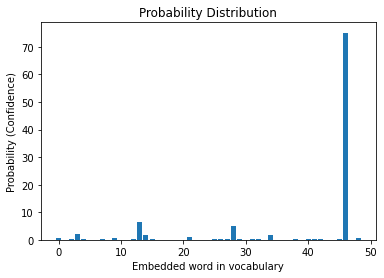

In [10]:
import torch
import torch.nn as nn
import math as m
import matplotlib.pyplot as plt
import numpy as np


def make_context_vector(context, word_to_ix): #make vector of surrounding words
    idxs = [word_to_ix[w] for w in context] 
    return torch.tensor(idxs, dtype=torch.long)

CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
EMDEDDING_DIM = 100

raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

vocab = set(raw_text) #Make vocab dictionary as subset of full raw text
vocab_size = len(vocab)
#print(len(raw_text))
#print(len(vocab))

word_to_ix = {word:ix for ix, word in enumerate(vocab)} #associate word with index of vocab vec
ix_to_word = {ix:word for ix, word in enumerate(vocab)}


#create training data
data = []
for i in range(CONTEXT_SIZE, len(raw_text) - CONTEXT_SIZE):
    context = (
        [raw_text[i - j - 1] for j in range(CONTEXT_SIZE)]
        + [raw_text[i + j + 1] for j in range(CONTEXT_SIZE)]
    )
    target = raw_text[i]
    data.append((context, target))
print(data[:5])

class CBOW(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()

        #out: 1 x emdedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()
        
        #out: 1 x vocab_size
        self.linear2 = nn.Linear(128, vocab_size)
        self.activation_function2 = nn.LogSoftmax(dim = -1)
        

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1,-1) #make linear vector
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        out = self.activation_function2(out)
        return out

    def get_word_emdedding(self, word):
        word = torch.tensor([word_to_ix[word]])
        return self.embeddings(word).view(1,-1)


model = CBOW(vocab_size, EMDEDDING_DIM) #Model is above using linear and ReLU like I previously practiced in PyTorch
loss_function = nn.NLLLoss() #Negative log likelihood loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.001) #SGD Optimizer

#TRAINING
for epoch in range(50):
    total_loss = 0 #count up total loss on the epoch

    for context, target in data:
        context_vector = make_context_vector(context, word_to_ix)  
        log_probs = model(context_vector)
        total_loss += loss_function(log_probs, torch.tensor([word_to_ix[target]]))

    optimizer.zero_grad() #reset gradient
    total_loss.backward()
    optimizer.step()

#TESTING
#context = ['People','create','to', 'direct']
#context=['other','abstract','called','data.']
context=['conjure','the','of','the']
context_vector = make_context_vector(context, word_to_ix)
a = model(context_vector)


#Print result
print(f'Raw Text: {" ".join(raw_text)}\n')
print(f'Context: {context}\n')
print(f'Prediction: {ix_to_word[torch.argmax(a[0]).item()]}')
conf=100*m.exp(max(a[0]))
print(f'Confidence: {m.trunc(conf)}%')

#PLOT
wordVec=[]
for i in range(len(a[0])):
    wordVec.append(i)
plotVec=a.detach().numpy()
plt.bar(wordVec,100*np.exp(plotVec[0]))
plt.title('Probability Distribution')
plt.xlabel('Embedded word in vocabulary')
plt.ylabel('Probability (Confidence)')
plt.show()

After successfully building this NN model, training, and testing the results, I am now interested in what changing the different components of the NN I built. This is done below by replacing the loss function and optimizers by ones I know to be generally more desireable.

### Replacing SGD with Adam optimizer 

[(['are', 'We', 'to', 'study'], 'about'), (['about', 'are', 'study', 'the'], 'to'), (['to', 'about', 'the', 'idea'], 'study'), (['study', 'to', 'idea', 'of'], 'the'), (['the', 'study', 'of', 'a'], 'idea')]
Raw Text: We are about to study the idea of a computational process. Computational processes are abstract beings that inhabit computers. As they evolve, processes manipulate other abstract things called data. The evolution of a process is directed by a pattern of rules called a program. People create programs to direct processes. In effect, we conjure the spirits of the computer with our spells.

Context: ['conjure', 'the', 'of', 'the']

Prediction: spirits
Confidence: 94%


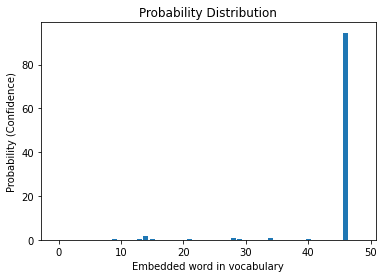

In [11]:
import torch
import torch.nn as nn
import math as m

def make_context_vector(context, word_to_ix): 
    idxs = [word_to_ix[w] for w in context] 
    return torch.tensor(idxs, dtype=torch.long)

CONTEXT_SIZE = 2 
EMDEDDING_DIM = 100

raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

vocab = set(raw_text)
vocab_size = len(vocab)
#print(len(raw_text))
#print(len(vocab))

word_to_ix = {word:ix for ix, word in enumerate(vocab)} 
ix_to_word = {ix:word for ix, word in enumerate(vocab)}


#create training data
data = []
for i in range(CONTEXT_SIZE, len(raw_text) - CONTEXT_SIZE):
    context = (
        [raw_text[i - j - 1] for j in range(CONTEXT_SIZE)]
        + [raw_text[i + j + 1] for j in range(CONTEXT_SIZE)]
    )
    target = raw_text[i]
    data.append((context, target))
print(data[:5])

class CBOW(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()

        #out: 1 x emdedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()
        
        #out: 1 x vocab_size
        self.linear2 = nn.Linear(128, vocab_size)
        self.activation_function2 = nn.LogSoftmax(dim = -1)
        

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1,-1) 
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        out = self.activation_function2(out)
        return out

    def get_word_emdedding(self, word):
        word = torch.tensor([word_to_ix[word]])
        return self.embeddings(word).view(1,-1)


model = CBOW(vocab_size, EMDEDDING_DIM) 
loss_function = nn.NLLLoss() #
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #Adam Optimizer


for epoch in range(50):
    total_loss = 0 

    for context, target in data:
        context_vector = make_context_vector(context, word_to_ix)  
        log_probs = model(context_vector)
        total_loss += loss_function(log_probs, torch.tensor([word_to_ix[target]]))

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()



#context = ['People','create','to', 'direct']
#context=['other','abstract','called','data.']
context=['conjure','the','of','the']
context_vector = make_context_vector(context, word_to_ix)
a = model(context_vector)


#Print result
print(f'Raw Text: {" ".join(raw_text)}\n')
print(f'Context: {context}\n')
print(f'Prediction: {ix_to_word[torch.argmax(a[0]).item()]}')
conf=100*m.exp(max(a[0]))
print(f'Confidence: {m.trunc(conf)}%')

wordVec=[]
for i in range(len(a[0])):
    wordVec.append(i)
plotVec=a.detach().numpy()
plt.bar(wordVec,100*np.exp(plotVec[0]))
plt.title('Probability Distribution')
plt.xlabel('Embedded word in vocabulary')
plt.ylabel('Probability (Confidence)')
plt.show()

As seen above, the use of Adam increased our confidence about 20%, which was expected.
### Replacing SGD with RMSProp optimizer 

[(['are', 'We', 'to', 'study'], 'about'), (['about', 'are', 'study', 'the'], 'to'), (['to', 'about', 'the', 'idea'], 'study'), (['study', 'to', 'idea', 'of'], 'the'), (['the', 'study', 'of', 'a'], 'idea')]
Raw Text: We are about to study the idea of a computational process. Computational processes are abstract beings that inhabit computers. As they evolve, processes manipulate other abstract things called data. The evolution of a process is directed by a pattern of rules called a program. People create programs to direct processes. In effect, we conjure the spirits of the computer with our spells.

Context: ['conjure', 'the', 'of', 'the']

Prediction: spirits
Confidence: 99%


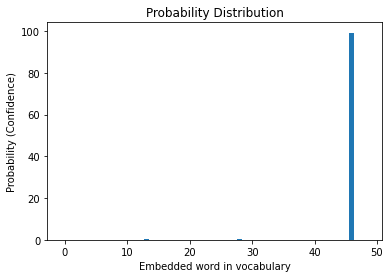

In [12]:
import torch
import torch.nn as nn
import math as m

def make_context_vector(context, word_to_ix): 
    idxs = [word_to_ix[w] for w in context] 
    return torch.tensor(idxs, dtype=torch.long)

CONTEXT_SIZE = 2 
EMDEDDING_DIM = 100

raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

vocab = set(raw_text)
vocab_size = len(vocab)
#print(len(raw_text))
#print(len(vocab))

word_to_ix = {word:ix for ix, word in enumerate(vocab)} 
ix_to_word = {ix:word for ix, word in enumerate(vocab)}


#create training data
data = []
for i in range(CONTEXT_SIZE, len(raw_text) - CONTEXT_SIZE):
    context = (
        [raw_text[i - j - 1] for j in range(CONTEXT_SIZE)]
        + [raw_text[i + j + 1] for j in range(CONTEXT_SIZE)]
    )
    target = raw_text[i]
    data.append((context, target))
print(data[:5])

class CBOW(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()

        #out: 1 x emdedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()
        
        #out: 1 x vocab_size
        self.linear2 = nn.Linear(128, vocab_size)
        self.activation_function2 = nn.LogSoftmax(dim = -1)
        

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1,-1) 
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        out = self.activation_function2(out)
        return out

    def get_word_emdedding(self, word):
        word = torch.tensor([word_to_ix[word]])
        return self.embeddings(word).view(1,-1)


model = CBOW(vocab_size, EMDEDDING_DIM) 
loss_function = nn.NLLLoss() 
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001) #RMSProp


for epoch in range(50):
    total_loss = 0 

    for context, target in data:
        context_vector = make_context_vector(context, word_to_ix)  
        log_probs = model(context_vector)
        total_loss += loss_function(log_probs, torch.tensor([word_to_ix[target]]))

    optimizer.zero_grad() 
    total_loss.backward()
    optimizer.step()


#context = ['People','create','to', 'direct']
#context=['other','abstract','called','data.']
context=['conjure','the','of','the']
context_vector = make_context_vector(context, word_to_ix)
a = model(context_vector)


#Print result
print(f'Raw Text: {" ".join(raw_text)}\n')
print(f'Context: {context}\n')
print(f'Prediction: {ix_to_word[torch.argmax(a[0]).item()]}')
conf=100*m.exp(max(a[0]))
print(f'Confidence: {m.trunc(conf)}%')


wordVec=[]
for i in range(len(a[0])):
    wordVec.append(i)
plotVec=a.detach().numpy()
plt.bar(wordVec,100*np.exp(plotVec[0]))
plt.title('Probability Distribution')
plt.xlabel('Embedded word in vocabulary')
plt.ylabel('Probability (Confidence)')
plt.show()

RMS Prop was even more confident!

## Conclusion
Now that I have thuroughly investigated the fundamentals of PyTorch and Continuous Bag of Words, I will bring my skills into collaboration with the whole Reign Team on our collaborative portion of the project. With my knowledge of "pretraining" data with CBOW, I can integrate CBOW with a CNN or RNN and see how this improves the training efficiency and accuracy of the models we create. Another cool application that I did not get to implemenet this week is comparing CBOW to Skip-Gram, which essentially follows the opposite process. I prioritized CNN and RNN integrations here because I know from experience these are the more important concepts.